In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests 

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

# define constants
tickerpair="ETCUSDT"
interval="1m"
from aver6_funcs import get_data
import pickle,tqdm

In [2]:
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)

In [3]:
subset_symbols[50]

'AGLD'

In [4]:
from concurrent.futures import ThreadPoolExecutor
import concurrent
import tqdm

def worker(ss, ii):
    try:
        tickerpair = ss + "USDT"
        if "USD" in ss:
            return None
        dfmpl = get_data(tickerpair, interval, limit=55000, type="data")
        print(ss,end=" ")
        return (dfmpl.copy(), tickerpair, ii)
    except ValueError:
        return None

In [6]:
%%time
assert False
dfmpl_list = []

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(worker, ss, ii): (ss, ii) for ii, ss in enumerate(subset_symbols[:])}
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            dfmpl_list.append(result)

XLM XRP ETH BTC SOL ARB DOGE LINK BNB OP ADA MATIC SNX BCH LTC HBAR EUR DAR 1INCH AVAX DYDX USTC MKR SHIB COMP LDO INJ FTM DOT GALA ACA LQTY NEAR MASK APE XEC TRX APT UNI RNDR FIL ATOM CFX AGIX LUNC AGLD LUNA AAVE EOS XMR ALGO FET GMT SAND ETC RDNT MANA TOMO WAVES AXS XTZ FLOW MAGIC STX ACH LINA CRV CELO BAND ONE VET ROSE ID CAKE EDU ICP OCEAN ARPA ANKR SUSHI RUNE GRT DASH ASTR GAL CHZ MINA FXS EGLD PAXG DUSK AR HIGH QNT KAVA STMX STG SSV ZEN IMX IOTX NEO ZIL THETA MC JASMY XVS SXP MOB ENJ ZEC MDT LPT AUDIO LRC GMX SKL TWT ENS HOOK CKB API3 WOO GBP KLAY VOXEL BNX RSR LIT UNFI JOE VGX UMA LOKA POLYX BEL ADX FIDA SYN KSM IOTA HFT T C98 PHB BAT RAD OMG ALICE REEF ICX VIDT QTUM ONT KEY IOST CHR XEM HOT RPL YFI AMB TRU PEOPLE KDA PYR ALPHA CTSI GLMR REN RVN BSW FLUX BLZ LEVER YGG BAKE TLM BURGER OG IDEX SLP BETH COTI DENT DODO OGN CTK ATA GTC LOOM BETA GNS POND CELR VIB KNC PLA CLV GHST OSMO CITY AMP ALPINE SANTOS CHESS BOND SPELL ILV RIF SFP TVK PORTO RARE BICO BTTC WAXP PHA KMD OAX MBL QI

In [ ]:
%%time
assert False
dfmpl_list=[]
#for ii,ss in enumerate(subset_symbols):
for ii,ss in tqdm.tqdm(enumerate(subset_symbols)):
    try:
        tickerpair=ss+"USDT"
        dfmpl = get_data(tickerpair,interval,limit=55000,type="data")
        #dfmpl.shape,tickerpair
        dfmpl_list.append((dfmpl.copy(),tickerpair,ii))
    except ValueError:
        pass

In [5]:
%%time
#with open("2_0_0dfmpl_list.pkl","wb")as f:
#    pickle.dump(dfmpl_list,f)
with open("2_0_0_analysisdata/2_0_0dfmpl_list.pkl","rb")as f:
    dfmpl_list = pickle.load(f)

CPU times: total: 266 ms
Wall time: 392 ms


In [6]:
dfmpl,_,_ = dfmpl_list[0]

In [7]:
v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values

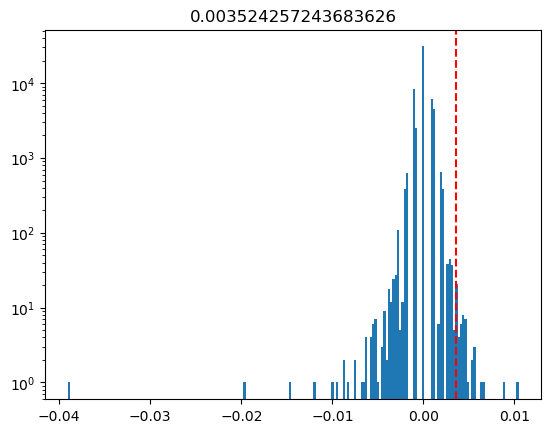

In [8]:
percentile_threshold = np.percentile(v,99.9)
plt.hist(v,bins=200);
plt.axvline(percentile_threshold,ls="--",c="r")
plt.title(percentile_threshold)
plt.yscale("log")

# when price falls twice in a row, 

In [9]:
%%time
threshold=-0.008
dfmpl,tickerpair,indd = dfmpl_list[0]
collated_data_list = []
all_locs = []
for dfmpl,tickerpair,_ in dfmpl_list:
    v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
    a1=np.where(v<threshold)[0]
    a2=np.diff(a1)
    a3=np.where(a2==1)
    def validate_df(loc):
        df_ = dfmpl.iloc[loc:loc+2]
        v0,v1 = (df_.Open*df_.Volume).values
        if v0>3e6 and v1>3e6:
            return True
        return False
    if len(a3)>0:
        locs=a1[a3]
        if len(locs)>0:
            collated_data = np.asarray([v[loc:loc+5] for loc in locs if validate_df(loc)])
            if len(collated_data)>0:
                print(tickerpair,len(collated_data),[loc for loc in locs if validate_df(loc)])
                [all_locs.append(loc)for loc in locs if validate_df(loc)]
                collated_data_list.append(collated_data)
    #len(locs)
collated_data = np.vstack(collated_data_list)
collated_data.shape

XRPUSDT 2 [37812, 37823]
ETHUSDT 1 [48686]
BTCUSDT 1 [48724]
SOLUSDT 2 [37793, 37804]
ARBUSDT 3 [857, 37756, 43944]
DOGEUSDT 7 [15191, 15202, 15244, 15321, 19674, 37648, 39403]
EDUUSDT 2 [101, 102]
CPU times: total: 969 ms
Wall time: 1.39 s


(18, 5)

In [10]:
sorted(all_locs)

[101,
 102,
 857,
 15191,
 15202,
 15244,
 15321,
 19674,
 37648,
 37756,
 37793,
 37804,
 37812,
 37823,
 39403,
 43944,
 48686,
 48724]

Text(0.5, 1.0, 'avg = +0.63%($\\pm$0.94%)')

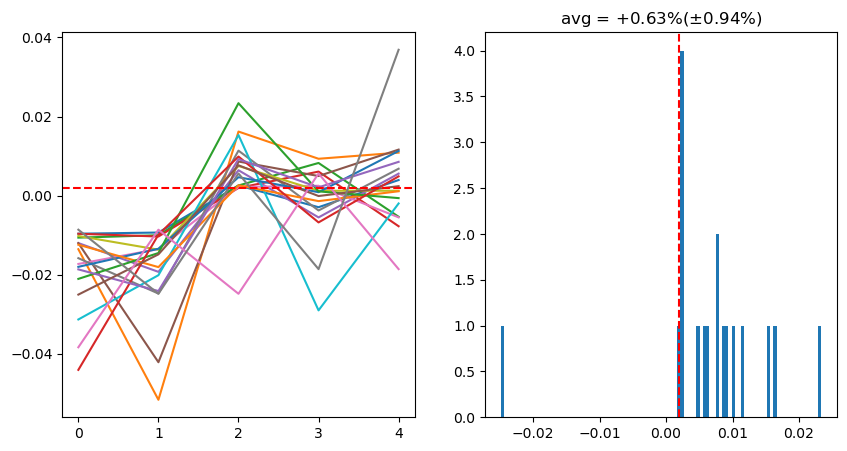

In [11]:
fig,axx=plt.subplots(1,2,figsize=(10,5))
ax=axx[0]
ax.plot(collated_data.T)
ax.axhline(0.002,ls="--",c="r")
ax=axx[1]
ax.hist(collated_data[:,2],bins=100);
ax.axvline(0.002,ls="--",c="r")
ax.set_title(f"avg = {np.mean(collated_data[:,2]):+.2%}($\pm${np.std(collated_data[:,2]):.2%})")

In [12]:
np.product(collated_data[:,2]+1-0.003)

1.0595611220946755

In [13]:
55000/60/24

38.19444444444444

In [18]:
listt_of_dfs = [1,2,3]

In [19]:
listt_of_dfs.pop(0)

1

In [20]:
listt_of_dfs

[2, 3]

In [21]:
listt_of_dfs.append(4)

In [22]:
listt_of_dfs

[2, 3, 4]

# trading implementation / algo

- subscribe to all data using websockets
- within each websocket instance, fetch data
- maintain a list of previous 2 candles
- once the current candle is determined to be changed, pop the list and append the new candle
    - then apply algorithm onto this list,
    - if criteria passed, send to master_trader.

In [1]:
import asyncio
from binance import AsyncClient, BinanceSocketManager
from binance.enums import *
import time
import datetime
from collections import Counter
import pickle
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)

In [ ]:
import subprocess


In [2]:
master_list=[[None] for _ in subset_symbols[:5]]
async def main(symbol='BNBBTC',idd=0):
    global master_list 
    await asyncio.sleep(idd*0.25)
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client) 
    ts = bm.kline_socket(symbol, interval=KLINE_INTERVAL_1MINUTE) 
    print(f"sub{idd}",end=" ")
    prev="0000";prev_df=[None]
    async with ts as tscm:
        while True:
            try:
                res = await tscm.recv() 
                if res["e"]=="error":
                    print(str(datetime.datetime.now())[11:-4],res)
                    raise Exception(res) 
                if prev != str(res["k"]["T"])[6:-3]: # a new change, so append the prev_df into the master_list
                    prev = str(res["k"]["T"])[6:-3]
                    ress=res["k"]
                    df = [ress["t"],float(ress["o"]),float(ress["c"]),float(ress["v"])] 
                    master_list[idd].append(prev_df.copy())
                    prev_df = df.copy()
                    if len(master_list[idd])>2:
                        master_list[idd].pop(0)
                        if master_list[idd][0] is not None:
                            # work on master_list since it has the latest dataset
                            dfloc0 = master_list[idd][0];dfloc1=master_list[idd][1]
                            v0 = dfloc0[1]*dfloc0[3];v1 = dfloc1[1]*dfloc1[3];
                            g0 = (dfloc0[2]-dfloc0[1])/dfloc0[1]
                            g1 = (dfloc1[2]-dfloc1[1])/dfloc1[1]
                            if v0>3e6 and v1>3e6 and g0<-0.008 and g1<-0.008:
                                #BUY signal!
                                cmd = ["python","aver6_master_trades.py",symbol,"15",str(datetime.datetime.now())[:-4],
                                       "TEST",f"{dfloc1[2]:.6g}","-0.008","-0.008","MOMENTUM","6969"]
                                cmd = " ".join(cmd)
                                subprocess.Popen( cmd , shell=True)
            except Exception as e:
                print(symbol,e,str(e))
                break
    await client.close_connection()
    print(f"ended {symbol}")

In [4]:
%%time
loop = asyncio.get_event_loop()
#loop.run_until_complete(main())
for idd,s in enumerate(subset_symbols[:5]):
    asyncio.run_coroutine_threadsafe(main(s+"USDT",idd), loop)
    #time.sleep(0.4)

CPU times: total: 0 ns
Wall time: 997 µs
sub0 sub1 sub2 sub3 sub4 some error at BTCUSDT
ended BTCUSDT
some error at XRPUSDT
some error at SOLUSDT
ended XRPUSDT
ended SOLUSDT
some error at XLMUSDT
ended XLMUSDT
some error at ETHUSDT
ended ETHUSDT


In [3]:
res={'e': 'kline',
 'E': 1690906998648,
 's': 'BNBBTC',
 'k': {'t': 1690906980000,
  'T': 1690907039999,
  's': 'BNBBTC',
  'i': '1m',
  'f': 225658046,
  'L': 225658048,
  'o': '0.00845600',
  'c': '0.00845600',
  'h': '0.00845600',
  'l': '0.00845600',
  'v': '0.27500000',
  'n': 3,
  'x': False,
  'q': '0.00232539',
  'V': '0.27500000',
  'Q': '0.00232539',
  'B': '0'}}
res

{'e': 'kline',
 'E': 1690906998648,
 's': 'BNBBTC',
 'k': {'t': 1690906980000,
  'T': 1690907039999,
  's': 'BNBBTC',
  'i': '1m',
  'f': 225658046,
  'L': 225658048,
  'o': '0.00845600',
  'c': '0.00845600',
  'h': '0.00845600',
  'l': '0.00845600',
  'v': '0.27500000',
  'n': 3,
  'x': False,
  'q': '0.00232539',
  'V': '0.27500000',
  'Q': '0.00232539',
  'B': '0'}}

In [4]:
ress=res["k"]
ress["t"],float(ress["o"]),float(ress["c"]),float(ress["v"])

(1690906980000, 0.008456, 0.008456, 0.275)

In [8]:
hehe=[23,4,1,5]

In [9]:
hehe2=hehe.copy()

In [10]:
hehe2[3]=123
hehe,hehe2

([23, 4, 1, 5], [23, 4, 1, 123])